In [1]:
import sys, os
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn

%matplotlib inline

assert sys.version_info >= (3, 5)
assert sklearn.__version__ >= '0.20'

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'ensembles'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print('Saving figure', fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# PCA分析

In [2]:
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

### 特異値分解

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [4]:
m, n = X.shape
S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s)

In [5]:
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [6]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2)

In [7]:
X2D_using_svd = X2D

### scikit-learn

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

#### 比較

In [11]:
np.allclose(X2D, -X2D_using_svd)

True

完全にはreverseできない

In [13]:
X3D_inv = pca.inverse_transform(X2D)

In [14]:
np.allclose(X3D_inv, X)

False

特徴量空間における主成分軸の向き

In [17]:
Vt

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ],
       [-0.08626012, -0.31420255,  0.94542898]])

In [15]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

因子寄与率

In [18]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

# MNIST 

In [19]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [22]:
d

154

In [23]:
pca = PCA(n_components=0.95)
pca.fit(X_train)

PCA(copy=True, iterated_power='auto', n_components=0.95, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [24]:
pca.n_components_

154

In [25]:
np.sum(pca.explained_variance_ratio_)

0.9503684424557421

In [26]:
pca = PCA(n_components=154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

# 逐次学習型PCA

In [30]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    print('.', end='')
    inc_pca.partial_fit(X_batch)
    
X_reduced = inc_pca.transform(X_train)

....................................................................................................

### memmap()

In [33]:
filename = 'my_mnist.data'
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [34]:
del X_mm

In [35]:
X_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

In [36]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

# 次元削減の比較

In [37]:
import time

for n_components in (2, 10, 154):
    print('n_components=', n_components)
    regular_pca = PCA(n_components=n_components, svd_solver='full')
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver='randomized')
    
    for name, pca in (('PCA', regular_pca), ('Inc PCA', inc_pca), ('Rnd PCA', rnd_pca)):
        t1 = time.time()
        pca.fit(X_train)
        t2 = time.time()
        print(' {}:{:.1f}seconds'.format(name, t2-t1))

n_components= 2
 PCA:83.4seconds
 Inc PCA:47.8seconds
 Rnd PCA:0.9seconds
n_components= 10
 PCA:83.2seconds
 Inc PCA:48.7seconds
 Rnd PCA:1.0seconds
n_components= 154
 PCA:87.2seconds
 Inc PCA:81.1seconds
 Rnd PCA:7.4seconds


Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

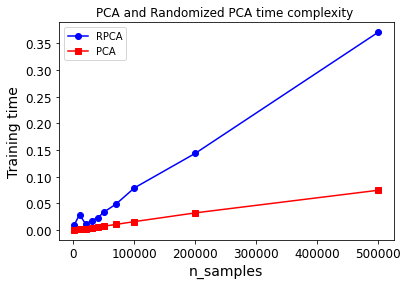

In [38]:
times_rpca = []
times_pca = []
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]
for n_samples in sizes:
    X = np.random.randn(n_samples, 5)
    pca = PCA(n_components=2, svd_solver="randomized", random_state=42)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_samples")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

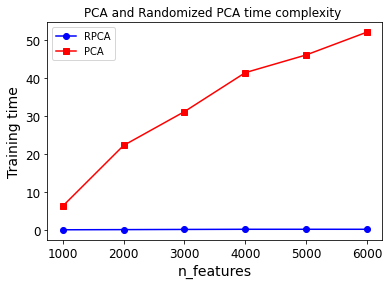

In [39]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components=2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components=2, svd_solver="full")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# Kernel PCA

In [40]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [41]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

# パラメータ調整

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

y = t > 6.9

clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression(solver='lbfgs'))
])

param_grid = [{
    'kpca__gamma':np.linspace(0.03, 0.05, 10),
    'kpca__kernel':['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=2,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [48]:
grid_search.best_params_

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}

In [49]:
rbf_pca = KernelPCA(n_components = 2, kernel='rbf', gamma=0.0433,
                   fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [50]:
from sklearn.metrics import mean_squared_error

mean_squared_error(X, X_preimage)

32.78630879576615

# 多様体学習

Saving figure swiss_roll_plot


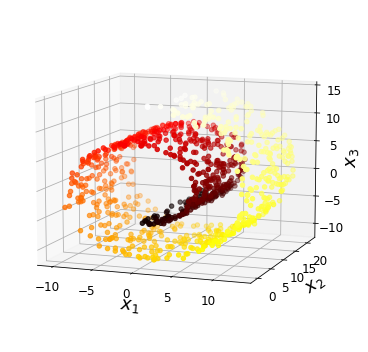

In [59]:
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

save_fig("swiss_roll_plot")
plt.show()

## LLE(Locally linear embedding)

In [52]:
from sklearn.manifold import LocallyLinearEmbedding

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


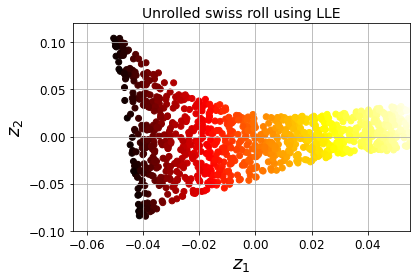

In [60]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.show()

## MDS, lsomap, t-SNE

### ① MDS
インスタンス間の距離を維持しようとしながら次元削除を行う

In [63]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

### ② Isomap
個々のインスタンスと複数の近傍インスタンスを結んでから
インスタンス間の測地距離を出来る限り維持しながら次元を削除する

In [75]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

### ③ t-SNE

似ているインスタンスを近くに保ち、似ていないインスタンスを遠くに遠ざけるように削減

In [70]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

### ④LDA

In [73]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist['data']
y_mnist = mnist['target']
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

Saving figure other_dim_reduction_plot


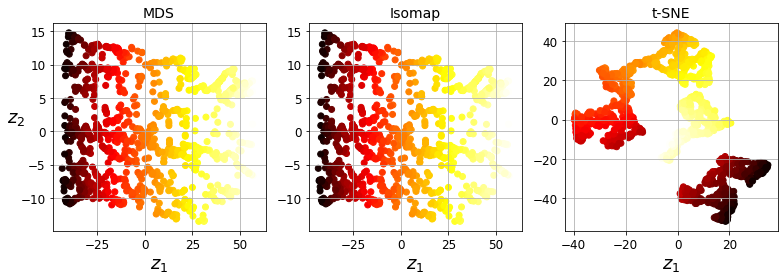

In [76]:

titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11,4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

# 演習問題

# 9

### ランダムフォレスト

In [98]:
X_train = mnist['data'][:60000]
y_train = mnist['target'][:60000]

X_test = mnist['data'][60000:]
y_test = mnist['target'][60000:]

In [81]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [82]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [83]:
print('Training took {:.2f}s'.format(t1 - t0))

Training took 37.88s


In [84]:
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9705

### PCA

In [99]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [103]:
rnd_clf2 = RandomForestClassifier(n_estimators=100, random_state=42)

t0 = time.time()
rnd_clf2.fit(X_train_reduced, y_train)
t1 = time.time()


In [104]:
print('Training took {:.2f}s'.format(t1 - t0))

Training took 92.06s


In [105]:
X_test_reduced = pca.transform(X_test)

y_pred = rnd_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9481

### ソフトマックス関数

In [107]:
from sklearn.linear_model import LogisticRegression

#softmax
log_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                            random_state=42)
t0 = time.time()
log_clf.fit(X_train, y_train)
t1 = time.time()

/Users/yuto/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [108]:
print('Training took {:.2f}s'.format(t1 - t0))

Training took 7.06s


In [109]:
y_pred = log_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9255

In [118]:
log_clf2 = LogisticRegression(multi_class='multinomial', solver='lbfgs',
                             random_state=42)
t0 = time.time()
log_clf2.fit(X_train_reduced, y_train)
t1 = time.time()

/Users/yuto/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [119]:
print('Training took {:.2f}s'.format(t1 - t0))

Training took 2.93s


In [120]:
y_pred = log_clf2.predict(X_test_reduced)
accuracy_score(y_test, y_pred)

0.9201

# 10

In [121]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [122]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

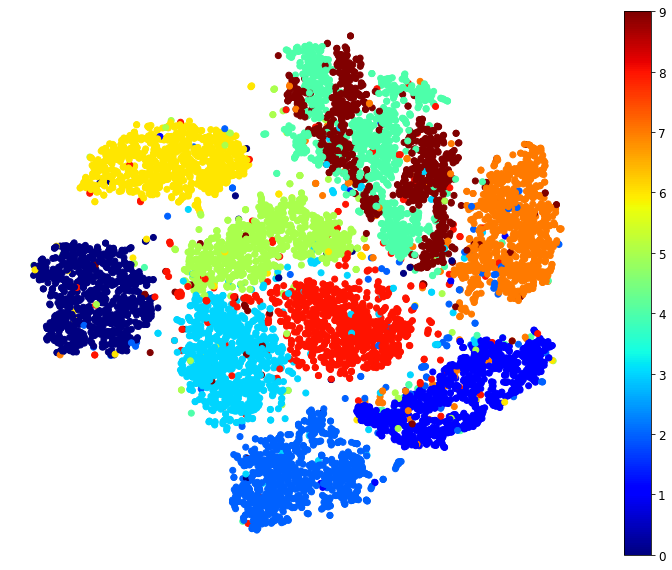

In [124]:
plt.figure(figsize=(13, 10))
plt.scatter(X_reduced[:,0], X_reduced[:,1], c=y, cmap='jet')
plt.axis('off')
plt.colorbar()
plt.show()

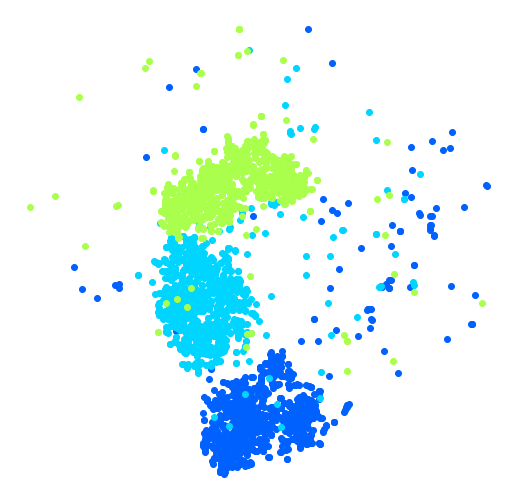

In [125]:
plt.figure(figsize=(9,9))
cmap = mpl.cm.get_cmap("jet")
for digit in (2, 3, 5):
    plt.scatter(X_reduced[y == digit, 0], X_reduced[y == digit, 1], c=[cmap(digit / 9)])
plt.axis('off')
plt.show()

In [126]:
idx = (y==2)|(y==3)|(y==5)
X_subset = X[idx]
y_subset = y[idx]

tsne_subset = TSNE(n_components=2, random_state=42)
X_subset_reduced = tsne_subset.fit_transform(X_subset)

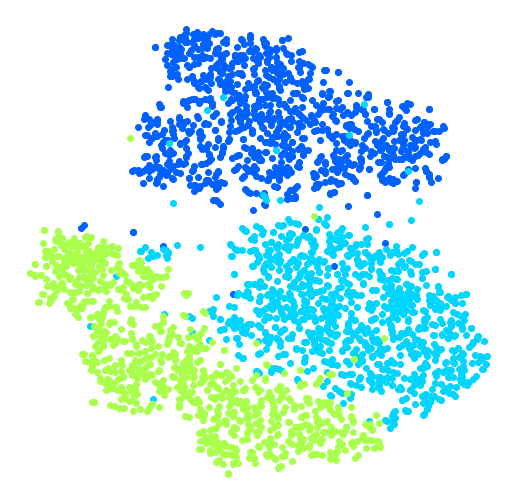

In [127]:
plt.figure(figsize=(9, 9))
for digit in (2, 3, 5):
    plt.scatter(X_subset_reduced[y_subset == digit, 0],
                X_subset_reduced[y_subset == digit, 1],
                c = [cmap(digit/ 9)]
               )
plt.axis('off')
plt.show()

In [139]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    
    X_normalized = MinMaxScaler().fit_transform(X)
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap('jet')
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0],
                   X_normalized[y == digit, 1],
                   c = [cmap(digit/9)])
    plt.axis('off')
    # gcf-->current figure
    # gca-->current axis
    ax = plt.gcf().gca()
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                        color = cmap(y[index]/9),
                        fontdict={'weight':'bold', 'size':16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap='binary'),
                                         image_coord)
                ax.add_artist(imagebox)

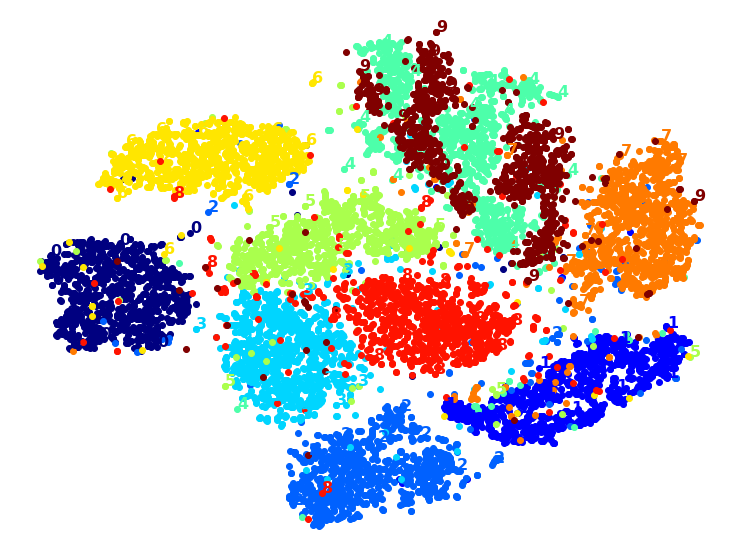

In [140]:
plot_digits(X_reduced, y)

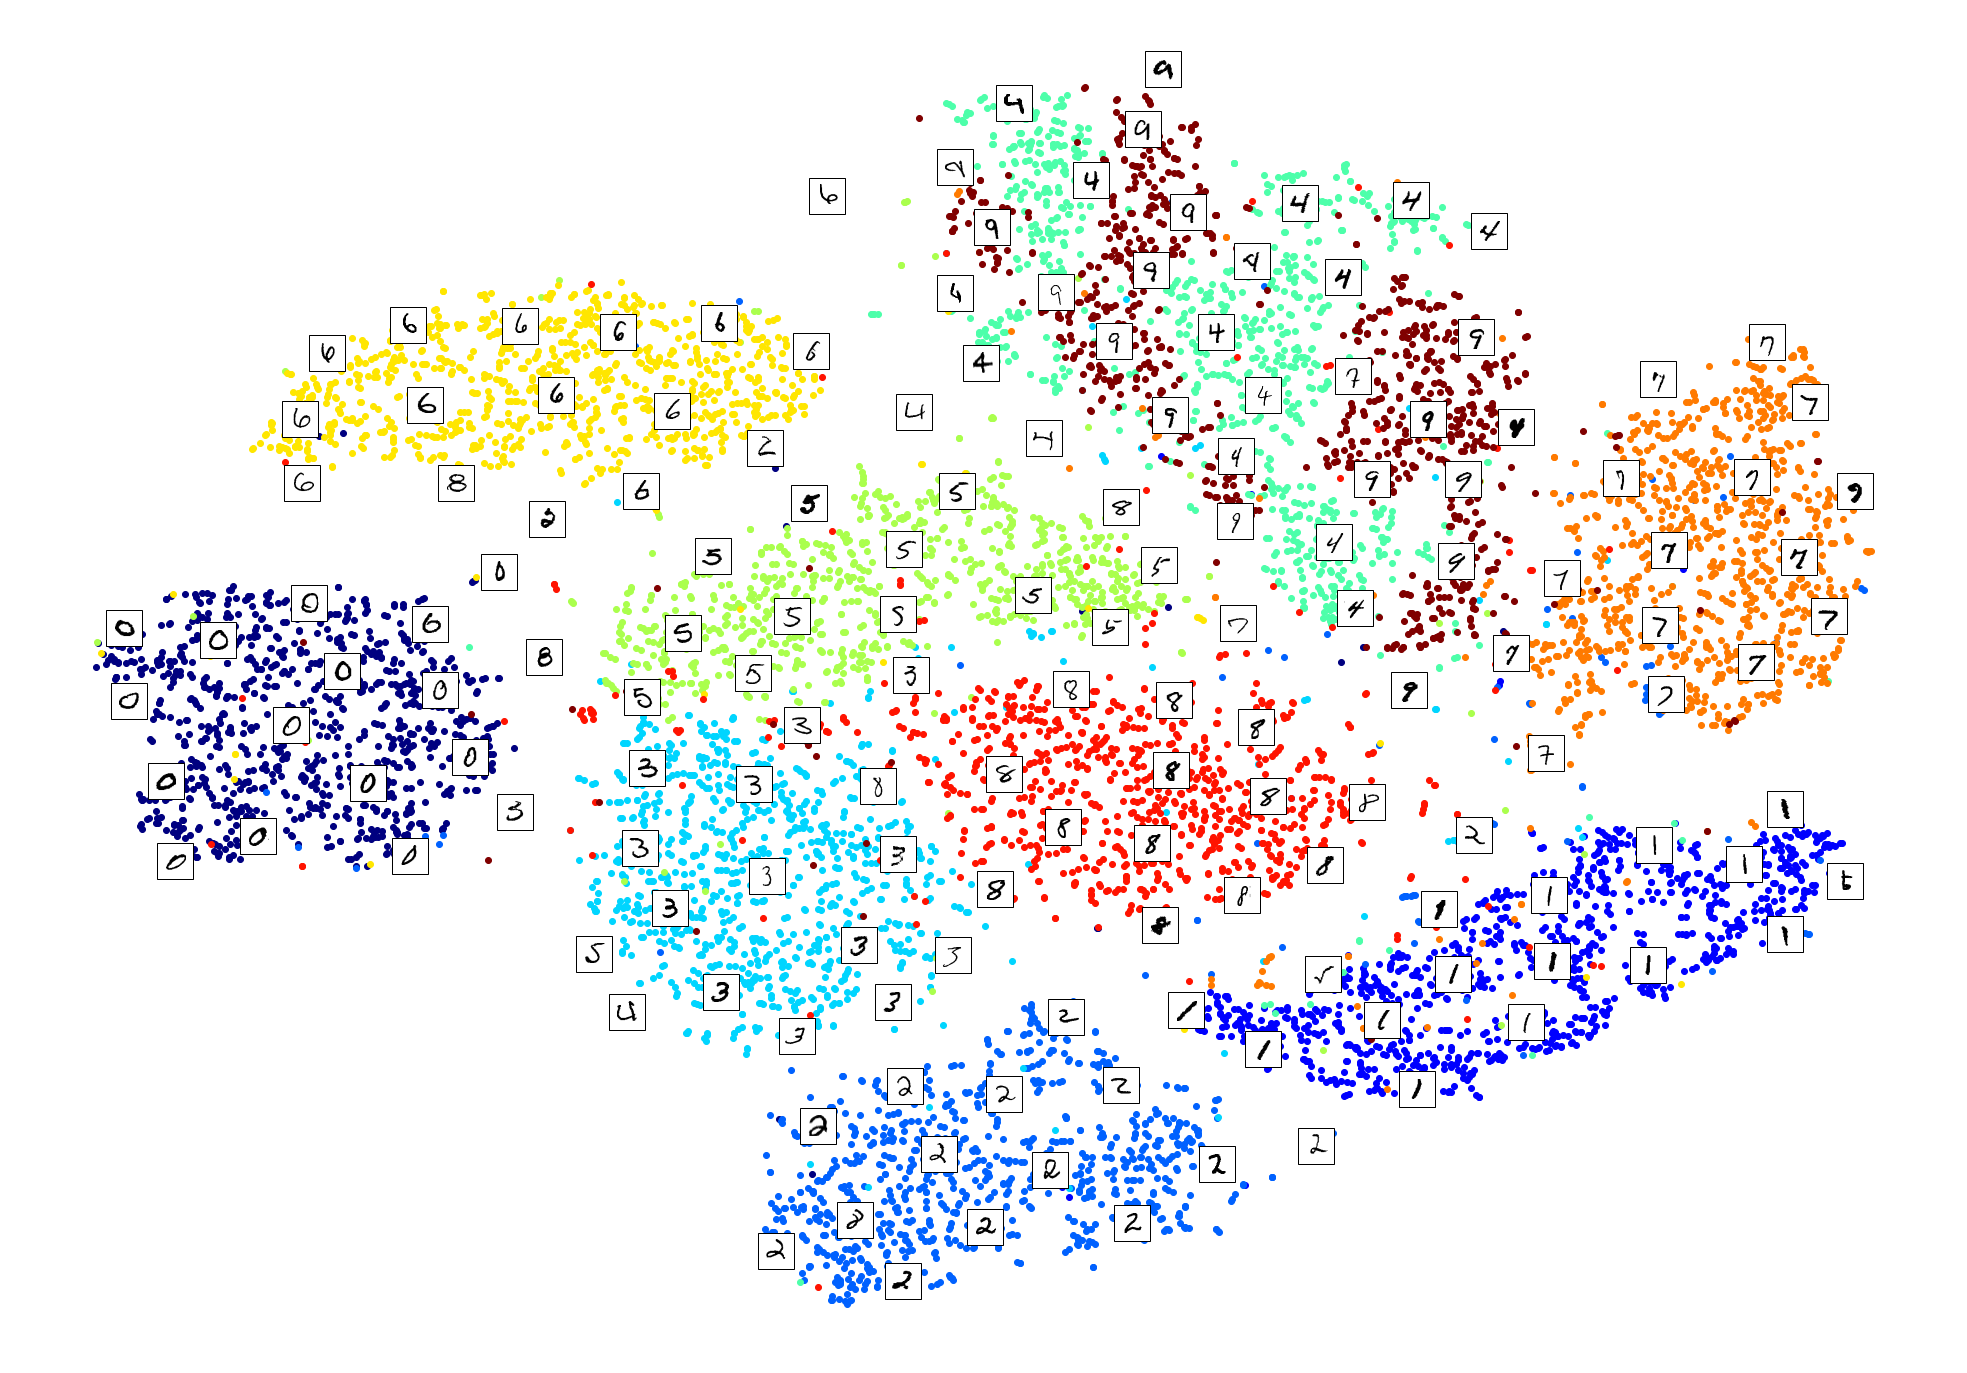

In [141]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))

## trying PCA, LLE, MDS

### PCA

it took 0.2s


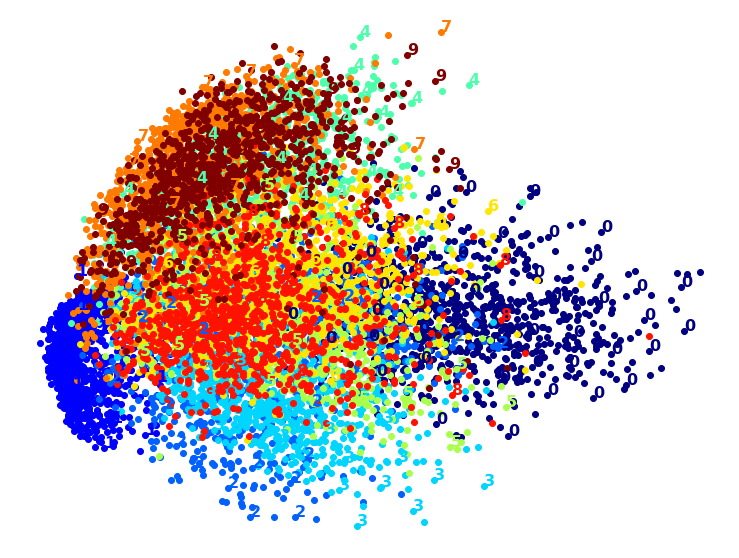

In [143]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()

print('it took {:.1f}s'.format(t1-t0))
plot_digits(X_pca_reduced, y)
plt.show()

## LLE

it took 136.4s


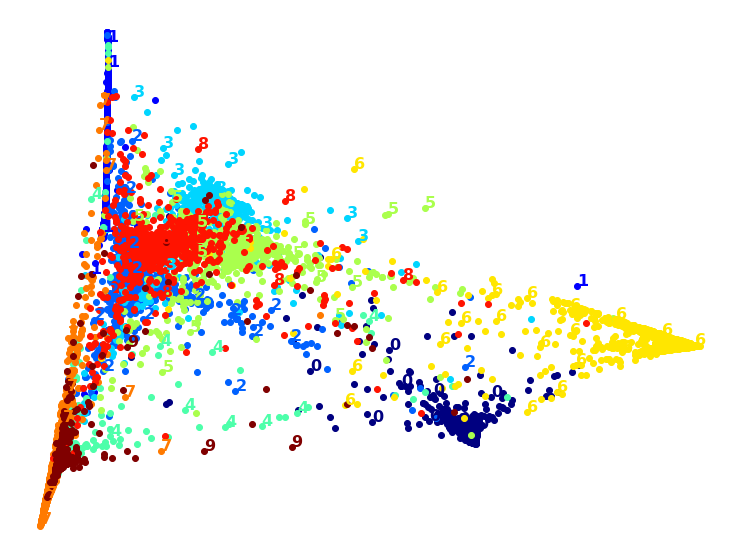

In [144]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()

print('it took {:.1f}s'.format(t1-t0))
plot_digits(X_lle_reduced, y)
plt.show()

## MDS and LLE

it took 53.4s


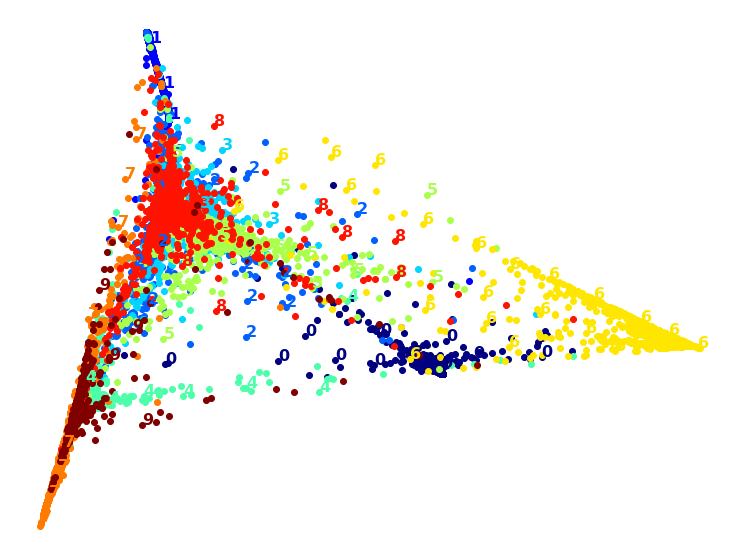

In [146]:
from sklearn.pipeline import Pipeline

pca_lle = Pipeline([
    ('pca', PCA(n_components=0.95, random_state=42)),
    ('lle', LocallyLinearEmbedding(n_components=2, random_state=42))
])

t0 = time.time()
X_pca_lle_reduced = pca_lle.fit_transform(X)
t1 = time.time()

print('it took {:.1f}s'.format(t1-t0))
plot_digits(X_pca_lle_reduced, y)
plt.show()

In [147]:
from sklearn.manifold import MDS

m = 2000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()

print('it took {:.1f}s'.format(t1-t0))
plot_digits(X_mds_reduced, y)
plt.show()

it took 83.1s


IndexError: boolean index did not match indexed array along dimension 0; dimension is 2000 but corresponding boolean dimension is 10000

<Figure size 936x720 with 0 Axes>

PCA+MDS took 87.3s (on 2,000 MNIST images).


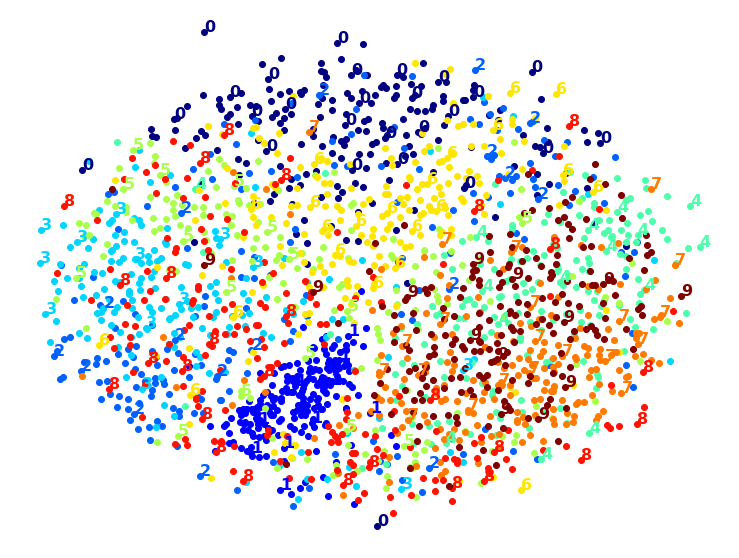

In [148]:
from sklearn.pipeline import Pipeline

pca_mds = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("mds", MDS(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_mds_reduced = pca_mds.fit_transform(X[:2000])
t1 = time.time()
print("PCA+MDS took {:.1f}s (on 2,000 MNIST images).".format(t1 - t0))
plot_digits(X_pca_mds_reduced, y[:2000])
plt.show()

it took 14.9s.


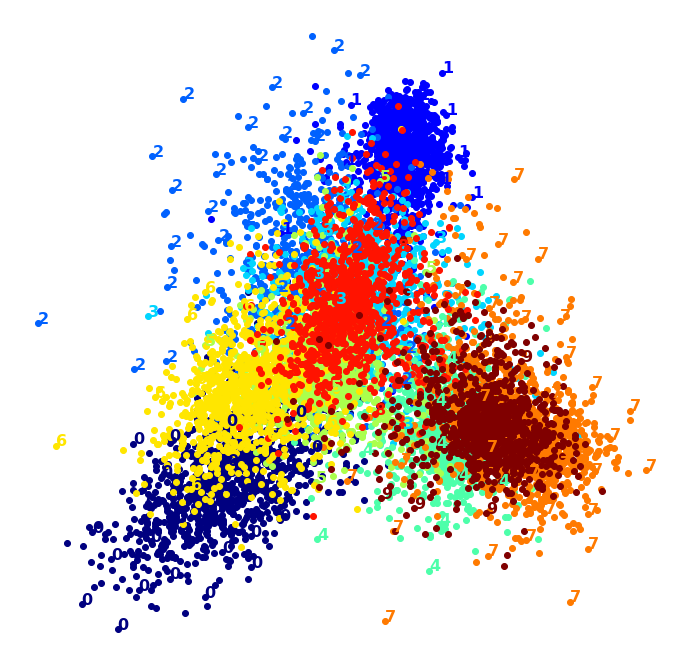

In [151]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

t0 = time.time()
X_lda_reduced = LinearDiscriminantAnalysis(n_components=2).fit_transform(X, y)
t1 = time.time()
print("it took {:.1f}s.".format(t1 - t0))
plot_digits(X_lda_reduced, y, figsize=(12,12))
plt.show()

it took 156.3s.


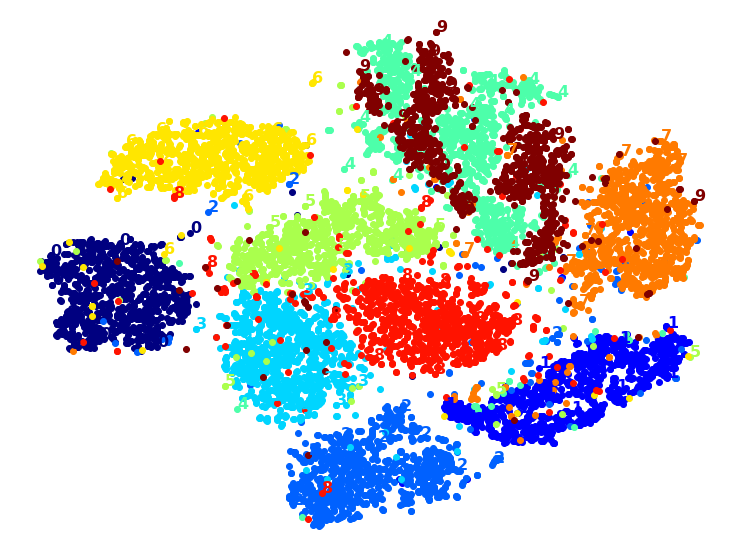

In [152]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("it took {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

it took 76.1s.


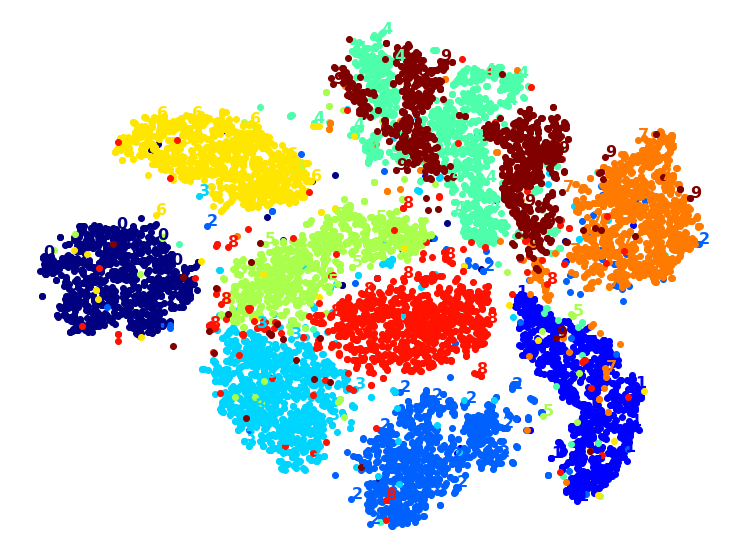

In [153]:
pca_tsne = Pipeline([
    ("pca", PCA(n_components=0.95, random_state=42)),
    ("tsne", TSNE(n_components=2, random_state=42)),
])
t0 = time.time()
X_pca_tsne_reduced = pca_tsne.fit_transform(X)
t1 = time.time()
print("it took {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_tsne_reduced, y)
plt.show()